## View your lifelog data usage trends!

In [6]:
%pip install pandas matplotlib requests
# Set your API key
API_KEY = "< your api key >"


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# imports and definitions

import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import date

def download_lifelogs(date_str=None, page_size=10):
    """
    Download lifelogs from the Limitless API with pagination.
    
    Args:
        date_str: Date in YYYY-MM-DD format (default: today)
        
    Returns:
        DataFrame with lifelog data including timestamps
    """
    # Use today's date if none provided
    if date_str is None:
        date_str = date.today().isoformat()
        
    # API endpoint from the schema
    url = "https://api.limitless.ai/v1/lifelogs"
    
    # Parameters based on the API schema
    params = {
        "date": date_str,
        "timezone": "America/Chicago",
        "includeMarkdown": "false",  # We only need timestamps, not content
        "direction": "asc",
        "limit": page_size,
        "includeHeadings": "false" # We only need transcript lines, not headings
    }
    
    # Replace with your actual auth method
    headers = {
        "X-API-Key": API_KEY
    }
    
    all_lifelogs = []
    
    while True:
        # Make the API request
        response = requests.get(url, params=params, headers=headers)
        
        # Check if request was successful
        if response.status_code != 200:
            raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
        
        # Parse the response
        data = response.json()
        
        # Extract lifelogs from the response structure
        lifelogs = data.get('data', {}).get('lifelogs', [])
        
        # If no more lifelogs, break the loop
        if not lifelogs:
            break
            
        all_lifelogs.extend(lifelogs)
        
        # Update offset for the next page
        next_cursor = data.get('meta', {}).get('lifelogs', {}).get('nextCursor', None)
        if next_cursor:
            params["cursor"] = next_cursor
        else:
            break
    
    # Create a list to store the data
    lifelog_data = []
    
    # Extract first and last start times from each lifelog
    for log in all_lifelogs:
        if 'contents' in log and log['contents']:
            # Only process if there are contents
            first_time = None
            last_time = None
            
            first_time = log['contents'][0]['startTime']
            last_time = log['contents'][-1]['startTime']
            lifelog_data.append({
                'first_timestamp': first_time,
                'last_timestamp': last_time
            })
    
    # Create DataFrame from the collected data
    df = pd.DataFrame(lifelog_data)
    
    # Convert timestamps to datetime objects
    if not df.empty:
        df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])
        df['last_timestamp'] = pd.to_datetime(df['last_timestamp'])
    
    return df


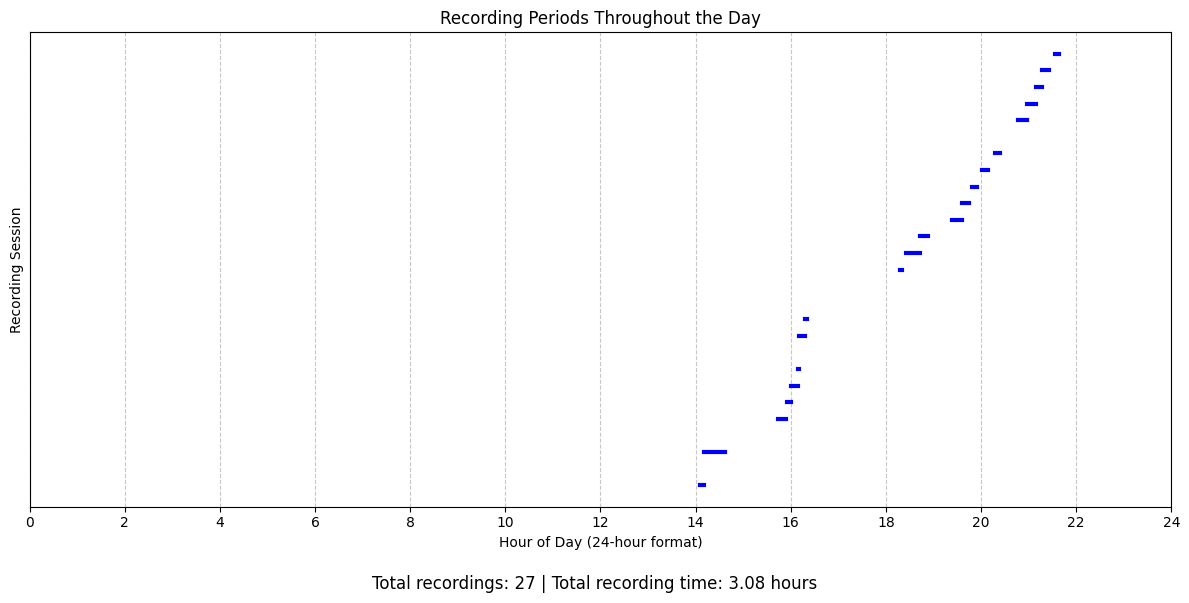

Total number of recording sessions: 27
Earliest recording started at: 14:05
Latest recording ended at: 21:38
Total recording time: 3.08 hours


In [10]:
# Download the lifelogs
df = download_lifelogs()

# Check if we have data
if df.empty:
    print("No lifelogs found for the specified date.")
else:
    # Create a timeline visualization showing recording periods
    plt.figure(figsize=(12, 6))
    
    # For each lifelog, draw a horizontal line from first to last timestamp
    for i, row in df.iterrows():
        start_hour = row['first_timestamp'].hour + row['first_timestamp'].minute/60
        end_hour = row['last_timestamp'].hour + row['last_timestamp'].minute/60
        
        # Draw a horizontal line for this recording period
        plt.plot([start_hour, end_hour], [i, i], linewidth=3, color='blue')
    
    # Add labels and title
    plt.title('Recording Periods Throughout the Day')
    plt.xlabel('Hour of Day (24-hour format)')
    plt.ylabel('Recording Session')
    
    # Format x-axis to show hours
    plt.xticks(range(0, 25, 2))
    plt.xlim(0, 24)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Remove y-axis ticks since they don't represent anything specific
    plt.yticks([])
    
    # Add a summary of total recording time
    total_recording_time = sum((row['last_timestamp'] - row['first_timestamp']).total_seconds()/3600 
                              for _, row in df.iterrows())
    
    # Adjust the layout to make room for the text at the bottom
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    
    plt.figtext(0.5, 0.01, 
                f"Total recordings: {len(df)} | Total recording time: {total_recording_time:.2f} hours", 
                ha="center", fontsize=12)
    
    # Show the plot
    plt.show()
    
    # Print some basic statistics
    earliest_recording = df['first_timestamp'].min().strftime('%H:%M')
    latest_recording = df['last_timestamp'].max().strftime('%H:%M')
    
    print(f"Total number of recording sessions: {len(df)}")
    print(f"Earliest recording started at: {earliest_recording}")
    print(f"Latest recording ended at: {latest_recording}")
    print(f"Total recording time: {total_recording_time:.2f} hours")